### 讀入基本套件 ###

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

/home/mingkai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mingkai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mingkai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mingkai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 資料預處理 ###

In [3]:
(x_train, y_train0), (x_test, y_test0) =  datasets.fashion_mnist.load_data() 

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

y_train = to_categorical(y_train0)
y_test = to_categorical(y_test0)

### 更改模型參數以及數量 ###

In [6]:
enc_1 = Dense(1000, activation = 'relu')
enc_2 = Dense(500, activation = 'relu')
enc_3 = Dense(50, activation = 'relu')

mean = Dense(2)
log_var = Dense(2)

dec_1 = Dense(50, activation = 'relu')
dec_2 = Dense(500, activation = 'relu')
dec_3 = Dense(1000, activation = 'relu')
dec_4 = Dense(x_train.shape[1], activation = 'sigmoid')


In [7]:
x = Input(shape = (784,))
enc_f1 = enc_1(x)
enc_f2 = enc_2(enc_f1)
enc_f3 = enc_3(enc_f2)

z_mean = mean(enc_f3)
z_log_var = log_var(enc_f3)

Instructions for updating:
Colocations handled automatically by placer.


### 定義抽樣方法 ###

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_f1 = dec_1(z)
dec_f2 = dec_2(dec_f1)
dec_f3 = dec_3(dec_f2)
x_hat = dec_4(dec_f3)


In [11]:
vae_model = Model(x, x_hat)

In [12]:
vae_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1000)         785000      input_1[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 500)          500500      dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 50)           25050       dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (

### 定義loss function ###

In [13]:
new_loss = x_train.shape[1] * losses.mean_squared_error(x, x_hat)

kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
kl_loss = K.sum(kl_loss, axis = 1)

vae_loss = K.mean(new_loss + kl_loss)
vae_model.add_loss(vae_loss)

In [14]:
vae_model.compile(optimizer = Adam())

In [15]:
vae_model.fit(x_train, batch_size = 100, epochs = 15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
60000/60000 [==============================] - 12s 194us/sample - loss: 38.3904
Epoch 2/15
60000/60000 [==============================] - 11s 187us/sample - loss: 30.1355
Epoch 3/15
60000/60000 [==============================] - 11s 187us/sample - loss: 28.7872
Epoch 4/15
60000/60000 [==============================] - 11s 187us/sample - loss: 28.2054
Epoch 5/15
60000/60000 [==============================] - 11s 187us/sample - loss: 27.7972
Epoch 6/15
60000/60000 [==============================] - 11s 187us/sample - loss: 27.5207
Epoch 7/15
60000/60000 [==============================] - 11s 187us/sample - loss: 27.2700
Epoch 8/15
60000/60000 [==============================] - 11s 187us/sample - loss: 27.1407
Epoch 9/15
60000/60000 [==============================] - 11s 187us/sample - loss: 26.9496
Epoch 10/15
60000/60000 [==============================] - 11s 187us/sample - loss: 26.7078
Epoch 11/15
60000/60000 [================

### encoder model ###

In [16]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_11 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
Total params: 1,310,652
Trainable params: 1,310,652
Non-trainable params: 0
_________________________________________________________________


### decoder model ###

In [17]:
z_input = Input(shape = (2,))
VAE_Decoder = Model(z_input, dec_4(dec_3(dec_2(dec_1(z_input)))))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_15 (Dense)             (None, 500)               25500     
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dense_17 (Dense)             (None, 784)               784784    
Total params: 1,311,434
Trainable params: 1,311,434
Non-trainable params: 0
_________________________________________________________________


### 抽取10000樣本 畫平均數分布圖 ###

In [18]:
indices = np.random.randint(x_train.shape[0], size=10000)

In [19]:
VAE_latents = VAE_Encoder.predict(x_train[indices])

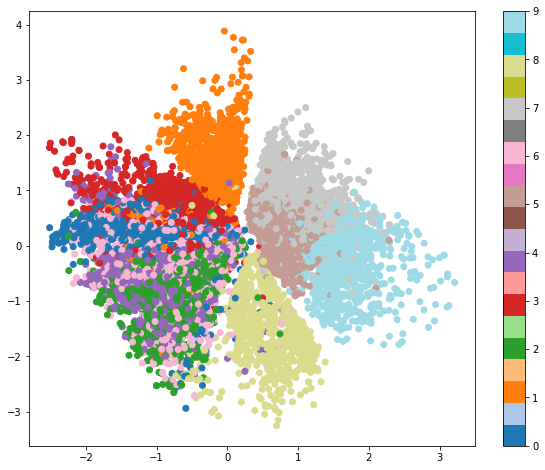

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

### 隨機取2張圖，看其變化 ###

In [21]:
from ipywidgets import interact, IntSlider, FloatSlider

In [22]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)

In [23]:
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])
    
    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')
    
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')
    
    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [24]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>